# Tutorial 5.2: Solving a linear elastic problem with a time dependent load
In this tutorial you will learn how solve a transient linear elastic problem in a 2D domain.

In this tutorial we will use the same setting of [Tutorial 5.1](../Module5/w5_t1_mesh_generation.ipynb), with the only difference of having a time dependent loading term. To solve the time-dependent problem we will discretize the PDE using Finite Elements and solve the resulting discrete ODE system with the built-in `solve_ivp` solver.

The time dependent loading will be given by an horizontal force in the right boundary of the structure with value:

$$F_x(t)=-10.0\ \sin(0.3t)$$

## 1. Generate the mesh
We will skip all the comments of this part as they are described in [Tutorial 5.1](../Module5/w5_t1_mesh_generation.ipynb).

In [6]:
import gmsh
gmsh.initialize()
gmsh.model.add("plate")

### 1.2. Create the geometry

In [7]:
H = 10.0
B = 5.0
t= 0.5
# Outer rectangle (last entry is the tag)
gmsh.model.occ.addRectangle(0.0,0.0,0.0,B,H,2)
# Inner rectangle (last entry is the tag)
gmsh.model.occ.addRectangle(t,t,0.0,B-2*t,H-2*t,3)
# Subtract inner from outer (notation: (dimension,tag)) 
structure = gmsh.model.occ.cut([(2,2)], [(2,3)], 4, True, True)

### 1.3. Assign entities

In [8]:
inner_boundary_line = gmsh.model.occ.getEntitiesInBoundingBox(t/2,t/2,-0.1,B-t/2,H-t/2,0.1,1)
inner_boundary_point = gmsh.model.occ.getEntitiesInBoundingBox(t/2,t/2,-0.1,B-t/2,H-t/2,0.1,0)
right_boundary_line = gmsh.model.occ.getEntitiesInBoundingBox(B-t/2,-0.1,-0.1,B+t/2,H+t/2,0.1,1)
right_boundary_point = gmsh.model.occ.getEntitiesInBoundingBox(B-t/2,-0.1,-0.1,B+t/2,H+t/2,0.1,0)
left_boundary_line = gmsh.model.occ.getEntitiesInBoundingBox(-t/2,-0.1,-0.1,t/2,H+t/2,0.1,1)
left_boundary_point = gmsh.model.occ.getEntitiesInBoundingBox(-t/2,-0.1,-0.1,t/2,H+t/2,0.1,0)
top_boundary_line = gmsh.model.occ.getEntitiesInBoundingBox(-t/2,H-t/2,-0.1,B+t/2,H+t/2,0.1,1)
bottom_boundary_line = gmsh.model.occ.getEntitiesInBoundingBox(-t/2,-t/2,-0.1,B+t/2,t/2,0.1,1)

# Get the tags only
inner_boundary_line_tags = [dim_tags[1] for dim_tags in inner_boundary_line]
inner_boundary_point_tags = [dim_tags[1] for dim_tags in inner_boundary_point]
right_boundary_line_tags = [dim_tags[1] for dim_tags in right_boundary_line]
right_boundary_point_tags = [dim_tags[1] for dim_tags in right_boundary_point]
left_boundary_line_tags = [dim_tags[1] for dim_tags in left_boundary_line]
left_boundary_point_tags = [dim_tags[1] for dim_tags in left_boundary_point]
top_boundary_line_tags = [dim_tags[1] for dim_tags in top_boundary_line]
bottom_boundary_line_tags = [dim_tags[1] for dim_tags in bottom_boundary_line]

gmsh.model.addPhysicalGroup(0,inner_boundary_point_tags,1,"inner")
gmsh.model.addPhysicalGroup(1,inner_boundary_line_tags,1,"inner")
gmsh.model.addPhysicalGroup(0,right_boundary_point_tags,2,"right")
gmsh.model.addPhysicalGroup(1,right_boundary_line_tags,2,"right")
gmsh.model.addPhysicalGroup(0,left_boundary_point_tags,3,"left")
gmsh.model.addPhysicalGroup(1,left_boundary_line_tags,3,"left")
gmsh.model.addPhysicalGroup(1,top_boundary_line_tags,4,"top")
gmsh.model.addPhysicalGroup(1,bottom_boundary_line_tags,5,"bottom")
gmsh.model.addPhysicalGroup(2,[4],5,"interior")

# Synchronize
gmsh.model.occ.synchronize()
gmsh.model.geo.synchronize()

gmsh.model.mesh.generate()

## 2. Read the mesh

In [9]:
nodes = gmsh.model.mesh.getNodes(-1)

import numpy as np
coords3D = nodes[1]
NoN = len(nodes[0])
NL = np.zeros([NoN,2])
for i in range(0,NoN):
    NL[i] = [coords3D[i*3], coords3D[i*3+1]]

elements = gmsh.model.mesh.getElements(2)

if elements[0][0] == 2:
    element_type = 'D2TR3N'
    NPE = 3

element_tags = elements[1][0]
NoE = len(element_tags)

EL = np.reshape(elements[2][0],[NoE,NPE])

## 3. Solve the linear elastic problem using Finite Element method

### 3.1 Discretize the geometry

Now that we have the discretized geometry, we can proceed as in the previous tutorial.

In [10]:
import math
import matplotlib.pyplot as plt

We can plot the mesh with the corresponding node and element identifiers:

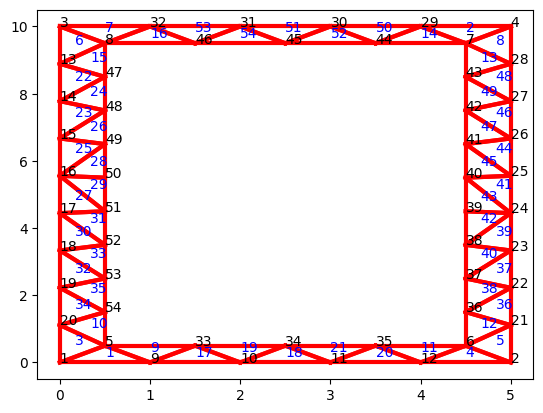

In [11]:
NoN = np.size(NL, 0)
NoE = np.size(EL, 0)

plt.figure(1)

count = 1
for i in range(0, NoN):
    plt.annotate(count, xy = (NL[i,0],NL[i,1]))
    count += 1

if element_type == 'D2QU4N':
    count2 = 1
    for j in range(0, NoE):
        plt.annotate(count2, xy = ((NL[EL[j,0]-1,0]+NL[EL[j,1]-1,0]+NL[EL[j,2]-1,0]+NL[EL[j,3]-1,0])/4,
                                   (NL[EL[j,0]-1,1]+NL[EL[j,1]-1,1]+NL[EL[j,2]-1,1]+NL[EL[j,3]-1,1])/4),
                                  c = 'blue')
        count2 += 1

    # Plot lines
    x0, y0 = NL[EL[:,0]-1,0], NL[EL[:,0]-1,1]
    x1, y1 = NL[EL[:,1]-1,0], NL[EL[:,1]-1,1]
    x2, y2 = NL[EL[:,2]-1,0], NL[EL[:,2]-1,1]
    x3, y3 = NL[EL[:,3]-1,0], NL[EL[:,3]-1,1]
    plt.plot(np.array([x0,x1]), np.array([y0,y1]), 'red', lw=3)
    plt.plot(np.array([x1,x2]), np.array([y1,y2]), 'red', lw=3)
    plt.plot(np.array([x2,x3]), np.array([y2,y3]), 'red', lw=3)
    plt.plot(np.array([x3,x0]), np.array([y3,y0]), 'red', lw=3)


if element_type == 'D2TR3N':

    count2 = 1
    for j in range(0, NoE):
        plt.annotate(count2, xy = ((NL[int(EL[j,0]-1),0]+NL[int(EL[j,1]-1),0]+NL[int(EL[j,2]-1),0])/3,
                                   (NL[int(EL[j,0]-1),1]+NL[int(EL[j,1]-1),1]+NL[int(EL[j,2]-1),1])/3),
                                  c = 'blue')
        count2 += 1

    # Plot lines
    x0, y0 = NL[EL[:,0]-1,0], NL[EL[:,0]-1,1]
    x1, y1 = NL[EL[:,1]-1,0], NL[EL[:,1]-1,1]
    x2, y2 = NL[EL[:,2]-1,0], NL[EL[:,2]-1,1]
    plt.plot(np.array([x0,x1]), np.array([y0,y1]), 'red', lw=3)
    plt.plot(np.array([x1,x2]), np.array([y1,y2]), 'red', lw=3)
    plt.plot(np.array([x2,x0]), np.array([y2,y0]), 'red', lw=3)

### 3.2. Define the shape functions
The second step in our Finite Element recipie consists on defining the shape functions and their derivatives. Here we will make use of the **isoparametric map** and **numerical integration** to re-use as much information as possible. 

Before defining the shape functions we first define the quadrature rule that will be used to integrate. Here we need to specify the location of the quadrature points and the corresponding weights. In this example we consider a $1$-point quadrature rule for the triangular elements. For the quadrilateral elements we define a $1$-point and $4$-point ($2\times2$) quadrature rule. See below an explanation about the reason why we need more quadrature points for quadrilaterals.

The function `GaussPoint` returns the coordinates $(\xi, \eta)$ of the quadrature point `gp` in the reference element, together with the corresponding weight $\alpha_{gp}$.

$$\int f(\xi,\eta) d\Omega_{ref} = \sum_{gp=1}^{GPE}f(\xi_{gp},\eta_{gp})\alpha_{gp}$$ 

In [12]:
def GaussPoint(NPE, GPE, gp): # Gaussian point theory needed
    if NPE == 3:
        if GPE == 1:
            if gp == 1:
                xi, eta, alpha = 1/3, 1/3, 1
    if NPE == 4:
        if GPE == 1:
            if gp == 1:
                xi, eta, alpha = 0, 0, 4
        if GPE == 4:
            if gp == 1:
                xi, eta, alpha = -1/math.sqrt(3), -1/math.sqrt(3), 1
            if gp == 2:
                xi, eta, alpha = 1/math.sqrt(3), -1/math.sqrt(3), 1
            if gp == 3:
                xi, eta, alpha = 1/math.sqrt(3), 1/math.sqrt(3), 1
            if gp == 4:
                xi, eta, alpha = -1/math.sqrt(3), 1/math.sqrt(3), 1

    return (xi, eta, alpha)

Using linear polynomials, we will have the following shape functions for triangular elements:

$$N_1(\xi,\eta)=\xi,\qquad N_2(\xi,\eta)=\eta, \qquad N_3(\xi,\eta)=1-\xi-\eta,$$

and the following shape functions for quadrilaterals:

$$N_1(\xi,\eta)=\frac{(1-\xi)}{2}\frac{(1-\eta)}{2},\qquad N_2(\xi,\eta)=\frac{(1+\xi)}{2}\frac{(1-\eta)}{2}, \qquad N_3(\xi,\eta)=\frac{(1+\xi)}{2}\frac{(1+\eta)}{2}, \qquad N_4(\xi,\eta)=\frac{(1-\xi)}{2}\frac{(1+\eta)}{2},$$

The function `grad_N_nat` returns the gradient of the shape functions evaluated at given point $(ξ,η)$. Using index notation, the returned value is:

$$\text{result[i,j]}=\frac{∂N_j}{∂ξ_i}.$$

Note that for the static linear elastic problem we did not need to define shape functions if the external distributed load is zero. However, when considering a transient problem, we will need the shape functions definition to build the mass matrix. This is done in the `N_nat` function.

In [13]:
def N_nat(NPE, xi, eta):

    result = np.zeros([NPE])

    if NPE == 3:
        result[0] = xi
        result[1] = eta
        result[2] = 1-xi-eta
    if NPE == 4:
        result[0] = 1/4*(1-xi)*(1-eta)
        result[1] = 1/4*(1+xi)*(1-eta)
        result[2] = 1/4*(1+xi)*(1+eta)
        result[3] = 1/4*(1-xi)*(1+eta)
    
    return result 

In [14]:
def grad_N_nat(NPE, xi, eta):

    PD = 2
    result = np.zeros([PD, NPE])

    if NPE == 3:
        result[0,0] = 1
        result[0,1] = 0
        result[0,2] = -1
        result[1,0] = 0
        result[1,1] = 1
        result[1,2] = -1
    if NPE == 4:
        result[0,0] = -1/4*(1-eta)
        result[0,1] = 1/4*(1-eta)
        result[0,2] = 1/4*(1+eta)
        result[0,3] = -1/4*(1+eta)
        result[1,0] = -1/4*(1-xi)
        result[1,1] = -1/4*(1+xi)
        result[1,2] = 1/4*(1+xi)
        result[1,3] = 1/4*(1-xi)
    
    return result 

### 3.3. Elemental matrices
Once we have the shape functions defined, we can proceed with the integration of the elemental matrices. The elemental stiffness matrix can be defined as:

$$K_{aibk}=\int_Ω C_{ijkl}\frac{∂N_a}{∂x_j}\frac{∂N_b}{∂x_l}\ dΩ$$

We first define a function to construct the constitutive tensor $C_{ijkl}$.

In [15]:
def constitutive(i, j, k, l):

    E = 8/3
    nu = 1/3
    C = (E/(2*(1+nu))) * (delta(i, l)*delta(j,k)) + delta(i,k)*delta(j,l) + (
                            E*nu)/(1-nu**2) * delta(i,j)*delta(k,l)
    
    return C

def delta(i,j):
    if i == j:
        delta = 1
    else:
        delta = 0
    return delta

The function `element_stiffness` computes the elemental stiffness matrix for a given local node list `nl` with the indices of the global nodes within an element. The function uses the array `NL` to retrieve the coordinates of the elemental nodes.

In [16]:
def element_stiffness(nl, NL):
    
    NPE = np.size(nl,0)
    PD = np.size(NL,1)

    x = np.zeros([NPE,PD])
    x[0:NPE, 0:PD] = NL[nl[0:NPE]-1, 0:PD]

    K = np.zeros([NPE*PD, NPE*PD])
    coor = x.T

    if NPE == 3:
        GPE = 1
    if NPE == 4:
        GPE = 4

    # Loop over test nodes
    for i in range(1, NPE+1):
        # Loop over solution nodes
        for j in range(1, NPE+1):

            # Local stiffness matrix ()
            k = np.zeros([PD,PD])
            for gp in range(1,GPE+1):
                J = np.zeros([PD,PD])
                grad = np.zeros([PD, NPE])
                (xi, eta, alpha) = GaussPoint(NPE, GPE, gp)
                grad_nat = grad_N_nat(NPE, xi, eta)
                J = coor @ grad_nat.T
                grad = np.linalg.inv(J).T @ grad_nat

                if NPE == 3:
                    for a in range(1, PD+1):
                        for c in range(1, PD+1):
                            for b in range(1, PD+1):
                                for d in range(1, PD+1):
                                    k[a-1,c-1] = k[a-1,c-1] + grad[b-1,i-1] * constitutive(
                                                    a,b,c,d) * grad[d-1,j-1] * np.linalg.det(J) * alpha*0.5
                if NPE == 4:
                    for a in range(1, PD+1):
                        for c in range(1, PD+1):
                            for b in range(1, PD+1):
                                for d in range(1, PD+1):
                                    k[a-1,c-1] = k[a-1,c-1] + grad[b-1,i-1] * constitutive(
                                                    a,b,c,d) * grad[d-1,j-1] * np.linalg.det(J) * alpha
                
                # Fill the global stiffness matrix
                K[((i-1)*PD+1)-1:i*PD, ((j-1)*PD+1)-1:j*PD] = k

    return K


In a transient problem we will need the mass matrix. This is computed in the following function. Note that we will re-use the same integration rule as in the stiffness matrix. However, for the mass matrix we would need more quadrature points to integrate the polynomial exactly. This is left as an exercise.

In [117]:
def element_mass(nl, NL):
    
    NPE = np.size(nl,0)
    PD = np.size(NL,1)

    x = np.zeros([NPE,PD])
    x[0:NPE, 0:PD] = NL[nl[0:NPE]-1, 0:PD]

    M = np.zeros([NPE*PD, NPE*PD])
    coor = x.T

    if NPE == 3:
        GPE = 1
    if NPE == 4:
        GPE = 4

    # We use a material density of 1500 kb/m3
    rho = 100

    # Loop over test nodes
    for i in range(1, NPE+1):
        # Loop over solution nodes
        for j in range(1, NPE+1):

            # Local stiffness matrix ()
            m = np.zeros([PD,PD])
            for gp in range(1,GPE+1):
                J = np.zeros([PD,PD])
                (xi, eta, alpha) = GaussPoint(NPE, GPE, gp)
                shape = N_nat(NPE, xi, eta)
                grad_nat = grad_N_nat(NPE, xi, eta)
                J = coor @ grad_nat.T
                detJ = np.linalg.det(J)

                if NPE == 3:
                    for a in range(1, PD+1):
                        for b in range(1, PD+1):
                            m[a-1,b-1] = m[a-1,b-1] + rho * shape[a-1] * delta(a,b) * shape[b-1] * detJ * alpha * 0.5
                            
                if NPE == 4:
                    for a in range(1, PD+1):
                        for b in range(1, PD+1):
                            m[a-1,b-1] = m[a-1,b-1] + rho * shape[a-1] * delta(a,b) * shape[b-1] * detJ * alpha
                
            # Fill the global mass matrix
            M[((i-1)*PD+1)-1:i*PD, ((j-1)*PD+1)-1:j*PD] = m

    return M

### 3.4. Assemble the global system

Once we have the elemental contributions we can assemble the global system. The function `assemble_stiffness` assembles the contribution of the elemental stiffness into the global matrix according to local-to-global nodal map. For this purpose we define an auxiliar array, `ENL`, with inforation about the coordinates, Dirichlet/Neumann boundary conditions and local-to-global degree of freedom numbering.

The `ENL` array is created calling the function `assign_BCs` with appropriate `BC_flag` and `defV` values.

Note that in this case we won't need to recompute the global mass and stiffness at each time step since the material properties are constant.

In [118]:
def assemble_stiffness(ENL, EL, NL):

    NoE = np.size(EL, 0)
    NPE = np.size(EL, 1)
    NoN = np.size(NL, 0)
    PD = np.size(NL, 1)

    K = np.zeros([NoN*PD, NoN*PD])

    for i in range(1, NoE):
        nl = EL[i-1,0:NPE]
        k = element_stiffness(nl, NL)
        for r in range(0, NPE):
            for p in range(0, PD):
                for q in range(0, NPE):
                    for s in range(0,PD):
                        row = ENL[int(nl[r]-1), p+3*PD]
                        column = ENL[int(nl[q]-1), s+3*PD]
                        value = k[r*PD+p, q*PD+s]
                        K[int(row)-1,int(column)-1] = K[int(row)-1,int(column)-1] + value
        
    return K

def assemble_mass(ENL, EL, NL):

    NoE = np.size(EL, 0)
    NPE = np.size(EL, 1)
    NoN = np.size(NL, 0)
    PD = np.size(NL, 1)

    M = np.zeros([NoN*PD, NoN*PD])

    for i in range(1, NoE):
        nl = EL[i-1,0:NPE]
        m = element_mass(nl, NL)
        for r in range(0, NPE):
            for p in range(0, PD):
                for q in range(0, NPE):
                    for s in range(0,PD):
                        row = ENL[int(nl[r]-1), p+3*PD]
                        column = ENL[int(nl[q]-1), s+3*PD]
                        value = m[r*PD+p, q*PD+s]
                        M[int(row)-1,int(column)-1] = M[int(row)-1,int(column)-1] + value
        
    return M

In this tutorial we will take advantage of the node tagging capabilities of `Gmsh` and use the function `getNodesForPhysicalGroup()` to extract the nodes at different boundaries. 

Here is where we will have to use the time `t` to assign the boundary condition values. Note that we add 4 more entries to store the value of prescribed velocities and accelerations.

In [129]:
def assign_BCs(NL,t):

    NoN = np.size(NL, 0)
    PD = np.size(NL, 1)
    # Extended node list, to fill in all "values" related to each node
    # 0-1 names NL, 2-3 xx, 4-5 xx, 6-7 xx, 8-9 displacements, 10-11 forces, 12-13 velocities, 14-15 accelerations
    # Dirichlet bounds have positive "value" or are "free" using -1 -- column 8-9
    # Neumann bounds are "free" using 0 -- column 10-11

    ENL = np.zeros([NoN, 8*PD])
    ENL[:,0:PD] = NL

    # Loop over dimensions (vertices and lines):
    for idim in range(0,2):
        # Nodes of the inner boundary: (Free traction)
        inner_nodes = gmsh.model.mesh.getNodesForPhysicalGroup(idim,1)[0]
        for i in inner_nodes:
            i = int(i-1)
            ENL[i,2] = 1
            ENL[i,3] = 1
            ENL[i,10] = 0
            ENL[i,11] = 0
        # Nodes of the right boundary: (Negative horizontal load)
        right_nodes = gmsh.model.mesh.getNodesForPhysicalGroup(idim,2)[0]
        for i in right_nodes:
            i = int(i-1)
            ENL[i,2] = 1
            ENL[i,3] = 1
            ENL[i,10] = -10.0*np.sin(0.3*t)
            ENL[i,11] = 0
        # Nodes of the left boundary: (Fixed zero displacement/velocity/acceleration)
        left_nodes = gmsh.model.mesh.getNodesForPhysicalGroup(idim,3)[0]
        for i in left_nodes:
            i = int(i-1)
            ENL[i,2] = -1
            ENL[i,3] = -1
            ENL[i,8] = 0
            ENL[i,9] = 0
            ENL[i,12] = 0
            ENL[i,13] = 0
            ENL[i,14] = 0
            ENL[i,15] = 0
        # Nodes of the top boundary: (Free traction)
        top_nodes = gmsh.model.mesh.getNodesForPhysicalGroup(idim,4)[0]
        for i in top_nodes:
            i = int(i-1)
            ENL[i,2] = 1
            ENL[i,3] = 1
            ENL[i,10] = 0
            ENL[i,11] = 0
        # Nodes of the bottom boundary: (Fixed zero displacement)
        bottom_nodes = gmsh.model.mesh.getNodesForPhysicalGroup(idim,5)[0]
        for i in bottom_nodes:
            i = int(i-1)
            ENL[i,2] = -1
            ENL[i,3] = -1
            ENL[i,8] = 0
            ENL[i,9] = 0
            ENL[i,12] = 0
            ENL[i,13] = 0
            ENL[i,14] = 0
            ENL[i,15] = 0
    
    DOFs = 0
    DOCs = 0
    for i in range(0, NoN):
        for j in range(0, PD):
            if ENL[i,PD+j] == -1: # if it is a Dirichlet bound
                DOCs -= 1 # it is a degree of constraint -- Global name
                ENL[i,2*PD+j] = DOCs # assign global DOC "name" to it
            else:
                DOFs += 1
                ENL[i,2*PD+j] = DOFs
    for i in range(0, NoN):
        for j in range(0, PD):
            if ENL[i,2*PD+j] < 0: # if it is a Neumann bound
                ENL[i,3*PD+j] = abs(ENL[i,2*PD+j])+DOFs
            else:
                ENL[i,3*PD+j] = abs(ENL[i,2*PD+j])
    DOCs = abs(DOCs)

    return (ENL, DOFs, DOCs)

We can use the function `assemble_forces` to apply Neumann type boundary conditions (traction at a boundary).

In [130]:
def assemble_forces(ENL, NL):
    
    PD = np.size(NL, 1)
    NoN = np.size(NL, 0)
    DOF = 0

    Fp = []
    for i in range(0, NoN):
        for j in range(0, PD):
            if ENL[i,PD+j] == 1: # if fixed node
                DOF += 1
                Fp.append(ENL[i,5*PD+j]) 
    Fp = np.vstack([Fp]).reshape(-1,1)
    return Fp

The function `assemble_displacement` prescribes the displacement at the Dirichlet boundary conditions.

In [131]:
def assemble_displacement(ENL, NL):
    
    PD = np.size(NL, 1)
    NoN = np.size(NL, 0)
    DOC = 0

    Up = []
    for i in range(0, NoN):
        for j in range(0, PD):
            if ENL[i,PD+j] == -1: # if fixed node
                DOC += 1
                Up.append(ENL[i,4*PD+j]) 
    Up = np.vstack([Up]).reshape(-1,1)
    return Up

def assemble_velocities(ENL, NL):
    
    PD = np.size(NL, 1)
    NoN = np.size(NL, 0)
    DOC = 0

    Vp = []
    for i in range(0, NoN):
        for j in range(0, PD):
            if ENL[i,PD+j] == -1: # if fixed node
                DOC += 1
                Vp.append(ENL[i,6*PD+j]) 
    Vp = np.vstack([Vp]).reshape(-1,1)
    return Vp

def assemble_accelerations(ENL, NL):
    
    PD = np.size(NL, 1)
    NoN = np.size(NL, 0)
    DOC = 0

    Ap = []
    for i in range(0, NoN):
        for j in range(0, PD):
            if ENL[i,PD+j] == -1: # if fixed node
                DOC += 1
                Ap.append(ENL[i,7*PD+j]) 
    Ap = np.vstack([Ap]).reshape(-1,1)
    return Ap

def update_nodes(ENL, Uu, NL, Fu):

    PD = np.size(NL, 1)
    NoN = np.size(NL, 0)

    DOFs = 0
    DOCs = 0
    for i in range(0, NoN):
        for j in range(0, PD):
            if ENL[i,PD+j] == 1:
                DOFs += 1
                ENL[i,4*PD+j] = Uu[DOFs-1] # update the displacement
            else:
                DOCs += 1
                ENL[i,5*PD+j] = Fu[DOCs-1]

    return ENL

## Main computation driver
We can use the functions defined above in the following main simulation driver:

In [132]:
# Computations
# Get initial BCs to determine fixed-free degrees of freedom (this does not change in time)
(ENL, DOFs, DOCs) = assign_BCs(NL,0.0)
# print(DOFs, DOCs)

K = assemble_stiffness(ENL, EL, NL)
M = assemble_mass(ENL, EL, NL)

K_UU = K[0:DOFs, 0:DOFs] 
K_UP = K[0:DOFs, DOFs:DOFs+DOCs]
K_PU = K[DOFs:DOFs+DOCs, 0:DOFs]
K_PP = K[DOFs:DOFs+DOCs, DOFs:DOFs+DOCs]

M_UU = M[0:DOFs, 0:DOFs]
M_UP = M[0:DOFs, DOFs:DOFs+DOCs]
M_PU = M[DOFs:DOFs+DOCs, 0:DOFs]
M_PP = M[DOFs:DOFs+DOCs, DOFs:DOFs+DOCs]

# Initial displacements and velocities:
Uu0 = np.zeros([DOFs,1])
Vu0 = np.zeros([DOFs,1])
q0 = np.append(Uu0,Vu0)

# ODE function
def odefun(t,q):
    (ENL, DOFs, DOCs) = assign_BCs(NL,t)
    Uu = q[0:DOFs]
    Vu = q[DOFs:]
    Fp = assemble_forces(ENL, NL)
    Up = assemble_displacement(ENL, NL)
    Vp = assemble_velocities(ENL, NL)
    Ap = assemble_accelerations(ENL, NL)
    RHS = Fp - (K_UU @ Uu).reshape(-1,1) - (K_UP @ Up) - (M_UP @ Ap)
    Au = np.linalg.solve(M_UU, RHS)
    return np.append(Vu,Au)

# Time span (output purposes)
tf = 10.0
tspan = np.arange(0, tf, tf/1e2)

# Solve the system
import scipy.integrate as scp
sol = scp.solve_ivp(fun=odefun, t_span=[tspan[0], tspan[-1]], y0=q0, t_eval=tspan) 

# Fu = M(K_PU @ Uu) + (K_PP @ Up)
# ENL = update_nodes(ENL, Uu, NL, Fu)

In [133]:
np.shape(K_UP)

(80, 28)

# Post-processing

In [134]:
def element_post_process(NL, EL, ENL):

    PD = np.size(NL, 1)
    NoE = np.size(EL, 0)
    NPE = np.size(EL, 1)
    if NPE == 3:
        GPE = 1
    if NPE == 4:
        GPE = 4
    # NoE = specified element
    # NPE = specified node in this element
    # PD = specifies x and y components
    # 1 = added to make the structure clear
    # Stress should be plotted using Gauss points

    disp = np.zeros([NoE, NPE, PD, 1]) 
    stress = np.zeros([NoE,GPE,PD,PD])
    strain = np.zeros([NoE,GPE,PD,PD])

    for e in range(1, NoE+1):
        nl = EL[e-1,0:NPE]

        # assign displacements to nodes
        for i in range(1,NPE+1):
            for j in range(1,PD+1):
                disp[e-1,i-1,j-1,0] = ENL[int(nl[i-1]-1),4*PD+j-1]
        
        # specify corners
        x = np.zeros([NPE,PD])
        x[0:NPE,0:PD] = NL[nl[0:NPE]-1,0:PD]
    
        # specify corner displacement
        u = np.zeros([PD, NPE])
        for i in range(1,NPE+1):
            for j in range(1,PD+1):
                u[j-1,i-1] = ENL[int(nl[i-1]-1),4*PD+j-1]
        
        # Do Gaus interpolation
        coor = x.T
        for gp in range(1,GPE+1):

            epsilon = np.zeros([PD,PD])
            for i in range(1, NPE+1):
                J = np.zeros([PD,PD])
                grad = np.zeros([PD, NPE])
                (xi, eta, alpha) = GaussPoint(NPE, GPE, gp)
                grad_nat = grad_N_nat(NPE, xi, eta)
                J = coor @ grad_nat.T
                grad = np.linalg.inv(J).T @ grad_nat

                # Calculate strain
                epsilon = epsilon + 1/2*(dyad(grad[:,i-1],u[:,i-1]
                                            ) + dyad(u[:,i-1],grad[:,i-1]))
            
            # Calculate stress
            sigma = np.zeros([PD,PD])
            for a in range(1,PD+1):
                for b in range(1,PD+1):
                    for c in range(1,PD+1):
                        for d in range(1,PD+1):
                            sigma[a-1,b-1] = sigma[a-1,b-1] + constitutive(a,b,c,d
                                                    ) * epsilon[c-1,d-1]
            for a in range(1,PD+1):
                for b in range(1,PD+1):
                    strain[e-1,gp-1,a-1,b-1] = epsilon[a-1,b-1]
                    stress[e-1,gp-1,a-1,b-1] = sigma[a-1,b-1] 

    return disp, stress, strain

def post_process(NL, EL, ENL):

    PD = np.size(NL, 1)
    NoE = np.size(EL, 0)
    NPE = np.size(EL, 1)
    scale = 0.1 # magnify deflection - here low E so not really needed

    disp, stress, strain = element_post_process(NL, EL, ENL)

    stress_xx = np.zeros([NPE,NoE])
    stress_xy = np.zeros([NPE,NoE])
    stress_yx = np.zeros([NPE,NoE])
    stress_yy = np.zeros([NPE,NoE])

    strain_xx = np.zeros([NPE,NoE])
    strain_xy = np.zeros([NPE,NoE])
    strain_yx = np.zeros([NPE,NoE])
    strain_yy = np.zeros([NPE,NoE])

    disp_x = np.zeros([NPE,NoE])
    disp_y = np.zeros([NPE,NoE])

    X = np.zeros([NPE,NoE])
    Y = np.zeros([NPE,NoE])

    if NPE in [3,4]:

        X = ENL[EL-1,0] + scale*ENL[EL-1,4*PD]
        Y = ENL[EL-1,1] + scale*ENL[EL-1,4*PD+1]
        X = X.T
        Y = Y.T

        stress_xx = stress[:,:,0,0].T
        stress_xy = stress[:,:,0,1].T
        stress_yx = stress[:,:,1,0].T
        stress_yy = stress[:,:,1,1].T

        strain_xx = strain[:,:,0,0].T
        strain_xy = strain[:,:,0,1].T
        strain_yx = strain[:,:,1,0].T
        strain_yy = strain[:,:,1,1].T

        disp_x = disp[:,:,0,0].T
        disp_y = disp[:,:,0,0].T

        stress_xx = stress[:,:,0,0].T
        stress_xx = stress[:,:,1,0].T

    return (stress_xx, stress_xy,  stress_yx, stress_yy, strain_xx, strain_xy,
            strain_yx, strain_yy, disp_x, disp_y, X, Y)

def dyad(u,v):
    u = u.reshape(len(v),1)
    v = v.reshape(len(v),1)
    A = u @ v.T
    return A

In [135]:
# Post-processing and plotting
def step_post_process(step):
    
    t=sol.t[step]
    (ENL, DOFs, DOCs) = assign_BCs(NL,t)
    Up = assemble_displacement(ENL, NL)
    Uu = sol.y[0:DOFs,step]
    print(max(Uu))
    Fu = (K_PU @ Uu).reshape(-1,1) + (K_PP @ Up)
    ENL = update_nodes(ENL, Uu, NL, Fu)

    (stress_xx, stress_xy, stress_yx, stress_yy, strain_xx, strain_xy,
    strain_yx, strain_yy, disp_x, disp_y, X, Y) = post_process(NL, EL, ENL)
    
    disp_xNormalized = (disp_x - disp_x.min()) / (disp_x.max() - disp_x.min())

    return X,Y,disp_xNormalized

import matplotlib.colors as mcolors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval,maxval,n)))
    return new_cmap

1.078506182860502


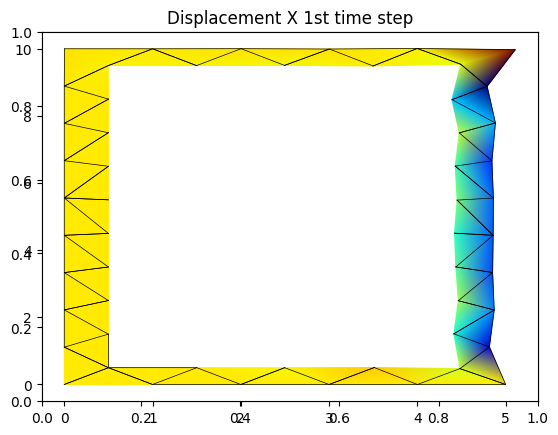

In [136]:
fig_1 =  plt.figure(1)
plt.title('Displacement X 1st time step')
axdisp_x = fig_1.add_subplot(111)

X,Y,disp_xNormalized = step_post_process(50)

for i in range(np.size(EL,0)):
    x = X[:,i]
    y = Y[:,i]
    c = disp_xNormalized[:,i]
    # gouraud smoothes the results
    cmap = truncate_colormap(plt.get_cmap('jet'),c.min(),c.max())
    t = axdisp_x.tripcolor( x,y,c,cmap=cmap, shading='gouraud')
    p = axdisp_x.plot(x,y,'k-',lw=0.5)


## Exercise

Modify the geometry of the problem and boundary conditions to solve the following cantiliver beam with hollow cross section.

<center><img src="https://github.com/TUDelft-CITG/ComModHOS/blob/main/book/images/Module5/exercise.png?raw=true" width="400" /></center>